Logs
- [2023/05/13]   
  Calculation of $F$-statistic is not the same as in the textbook.
  We use `lmfit` library because it provides us with the standard errors of
  the estimators.
  We have tried manually usinc `scipy.optimize`, but the calculation
  of `hat_Y` is not easy (we have to solve the $N-1$ linear equations
  for all $\hat{Y}_t$)
  $$
  \begin{align*}
    \hat{Y}_2 - \hat{\rho} \, \hat{Y}_1 
      &= \hat{\beta}_0(1 - \hat{\rho}) + \hat{\beta}_1 X'_2 \\
    \hat{Y}_3 - \hat{\rho} \, \hat{Y}_2 
      &= \hat{\beta}_0(1 - \hat{\rho}) + \hat{\beta}_1 X'_3 \\ 
    \vdots \\
    \hat{Y}_N - \hat{\rho} \, \hat{Y}_{N-1}
      &= \hat{\beta}_0(1 - \hat{\rho}) + \hat{\beta}_1 X'_N
  \end{align*}
  $$

  Calculation of log-likelihood follow the defintion of likelihood when
  the error follow normal distribution
  $$
  \begin{align*}
    \prod^N_{t=1} p(Y_t | X_t; \beta_0, \beta_1, \sigma^2_\nu )
      = \prod^N_{t=1} \frac{1}{\sqrt{2\pi \sigma^2_\nu}}
          \exp\left\{
            -\frac{(Y_t - (\beta_0 + \beta_1 X_t))^2}{2 \sigma^2_\nu}
          \right\}
  \end{align*}
  $$
  and the log-likelihood $L(\beta_0, \beta_1, \sigma^2_\nu)$ is
  $$
  \begin{align*}
    L(\beta_0, \beta_1, \sigma^2_\nu)
      &= \log \prod^N_{t=1} p(Y_t | X_t; \beta_0, \beta_1, \sigma^2_\nu ) \\
      &= \sum^N_{t=1} \log p(Y_t | X_t; \beta_0, \beta_1, \sigma^2_\nu ) \\
      &= -\frac{n}{2} \log{2\pi} - n \log{\sigma_\nu} 
          - \frac{1}{2\sigma^2_\nu} 
            \sum^N_{t=1} (Y_t - (\beta_0 + \beta_1 X_t))^2
  \end{align*}
  $$

# Example 7.5 - Autocorrelated Errors and Generalized Difference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc_stats
import scipy.optimize as sc_optimize
import tabulate
import lmfit
import json

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import plotly.graph_objects as go

from odf.opendocument import load as odf_load

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})


## Function declarations

### Read `ods` to `DataFrame`

In [3]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(columns, list):
    df = pd.read_excel(filename, engine="odf", header=0,
                       usecols=columns)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=key_arr)
    df = df.rename(columns=columns)
  return df

### Standard error of autocorrelation

In [91]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)

### Compute `r_k`, `t_test`, and `LBQ`

In [92]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result


### Plot of autocorrelation function

In [93]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


### Get multiple regression coefficients

In [4]:
def get_multiple_regress_coeff(df, n_vars=2, with_intercept=True):  

  regress_obj = LinearRegression(fit_intercept=with_intercept)

  if isinstance(df, pd.DataFrame):
    num_of_samples = len(df)
    X_arr = np.zeros((num_of_samples, n_vars))
    Y = df["Y"].to_numpy()

    for i in range(n_vars):
      key = f"X_{i+1}"
      X_arr[:, i] = df[key].to_numpy()

    regress = regress_obj.fit(X_arr, Y)
    df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 
  
  elif isinstance(df, np.ndarray):
    Y = df[:, 0]
    X_arr = df[:, 1:]

    
    regress = regress_obj.fit(X_arr, Y)
    Y_hat = regress.intercept_ + X_arr.dot(regress.coef_)
    df = np.column_stack([df, Y_hat])

  return regress, df


### Get Minitab output of Regression Analysis

In [115]:
def get_minitab_out(df, n_vars=2, new_column=None, withCorrMatrix=False, 
  withVIF=False, with_intercept=True, is_reg_diff=False):

  """
  new_column (dict) : a dictionary mapping to rename df header
  is_reg_diff:
    True - if we perform regression difference of Y_t and X_t
  """
  
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]

  # -- compute correlation matrix
  corr_matrix = np.corrcoef(data_struct, rowvar=False)
  corr_matrix = corr_matrix[1:, 0:-1]    # only show lower triangle part of correlation matrix

  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars, with_intercept=with_intercept)
  b_arr = [regress.intercept_] + regress.coef_.tolist()
  is_positive_b_arr = [b_j > 0 for b_j in b_arr]
  #print(f"b_arr: {b_arr}")
  
  # -- compute standad error of the estimates
  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  sumSq_Y_hat_Y = ((data_struct[:, 0] - hat_Y)**2).sum()

  if with_intercept:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars - 1))
  else:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars))

  # -- compute cofactor matrix 
  if with_intercept:
    X_arr = np.ones_like(data_struct)
    X_arr[:,1:] = data_struct[:,1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  else:
    X_arr = data_struct[:, 1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  

  # -- compute standard error of intercept_ and coef_
  # -- compute t-score of intecept_ and coef_
  # -- compute p-values of intercept_ and coef_
  SE_coef = np.zeros(1+n_vars)
  t_scores = np.zeros(1+n_vars)
  p_values = np.zeros(1+n_vars)
  
  if with_intercept:
    dof = num_of_samples - n_vars - 1;          # degrees of freedom
    for i in range(1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i, i])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)
  else:
    dof = num_of_samples - n_vars;          # degrees of freedom
    for i in range(1, 1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i-1, i-1])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)

  # -- compute VIF of coef_
  if withVIF:
    # if n_vars == 2, we calculate VIF from correlation matrix
    VIF_arr = np.zeros(n_vars)
    if n_vars == 2:
      VIF_arr[0] = 1/(1-corr_matrix[1, 1]**2)
      VIF_arr[1] = 1/(1-corr_matrix[1, 1]**2)
    else:
      for i in range(n_vars):
        # take a predictor column and put the other predictor after it
        predictor_data_struct = np.zeros((num_of_samples, n_vars))
        predictor_data_struct[:,0] = data_struct[:, i+1]   
        predictor_data_struct[:,1:] = np.delete(data_struct, i+1, axis=1)[:,1:]  
        #print(predictor_data_struct)
        predictor_SST, predictor_SSR, _ = get_sumSq(predictor_data_struct, n_vars=n_vars)
        predictor_R_sq = predictor_SSR/predictor_SST
        #print(predictor_R_sq)
        VIF_arr[i] = 1/(1 - predictor_R_sq)


  # -- compute ANOVA table
  meanY = data_struct[:, 0].mean()
  if with_intercept:
    SSR = ((hat_Y - meanY)**2).sum()
    SST = ((data_struct[:, 0] - meanY)**2).sum()
  else:
    SSR = (hat_Y**2).sum()
    SST = (data_struct[:, 0]**2).sum()

  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])

  if with_intercept:
    anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  else:
    anova_dof = np.array([n_vars, num_of_samples - n_vars, num_of_samples], dtype=int)
  
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a surfifal function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR/SST

  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(num_of_samples-1)/(num_of_samples-n_vars-1)
  
  # -- calculate Durbin-Watson statistics
  e_t = data_struct[:, 0] - hat_Y
  numerator = ((e_t[1:] - e_t[:-1])**2).sum()
  dw_stats = numerator / (e_t**2).sum()

  # -- create tabular form for correlation 
  if withCorrMatrix:
    data = []
    for i in range(n_vars):
      data_row = [new_column[i+1]] + \
        [f"{corr:.3f}" if j < i+1 else "" for j, corr in enumerate(corr_matrix[i,:])]
      #print(data_row)
      #print([type(data_row_i) for data_row_i in data_row])
      data.append(data_row)

    table_corr = tabulate.tabulate(data, tablefmt='html', 
      headers=[""] + new_column[:n_vars], 
      floatfmt=["None"] + [".3f"]*(n_vars))

    print(f"Correlations: {', '.join(new_column)}")
    display(table_corr)

  # -- create tabular form for predictor
  data = [["Constant", b_arr[0], SE_coef[0], t_scores[0], p_values[0]]]
  if withVIF:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i], VIF_arr[i-1]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value", "VIF"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f", ".3f"])
  else:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f"])


  print(f"Regression Analysis: {new_column[0]} versus {', '.join(new_column[1:])}")
  print("The regression equation is")
  str_b_predictor = "" 
  for i in range(n_vars):
    sign = "+" if is_positive_b_arr[i+1] else "-"
    str_b_predictor += f" {sign} {abs(b_arr[i+1]):.3f} {new_column[i+1]}"
  if with_intercept:
    print(f"{new_column[0]} = {b_arr[0]:.3f}{str_b_predictor}")
  else:
    if str_b_predictor[1] == "+":
      str_b_predictor = str_b_predictor[3:]
    print(f"{new_column[0]} = {str_b_predictor}")
  display(table_predictor)
  if is_reg_diff:
    print(f"s_yxs = {s_yxs:.4f}")
  else:
    print(f"s_yxs = {s_yxs:.4f}   R_sq = {R_sq*100:.1f}%   R-sq(adj) = {adj_R_sq*100:.1f}%")

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.4f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.4f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".4f", "s", "s", "s"])

  print(f"Analyis of Variance")
  display(table_anova)

  # -- print Durbin-Watson statistics
  print(f"Durbin-Watson Statistics = {dw_stats:.2f}")

  return {"regress": regress, "param_stderr": SE_coef, 
    "param_t_stat": t_scores, "param_p_vals": p_values,
    "corr_matrix": corr_matrix, "R_sq": R_sq, "dw_stats": dw_stats}


### Perform Durbin-Watson Test

In [6]:
def test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl_arr):
  for significance_lvl in significance_lvl_arr:
    if abs(significance_lvl - 0.05) < 1e-4:
      d_lower = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")
      
    elif abs(significance_lvl - 0.01) < 1e-4:
      d_lower = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")

    test_status = "" 
    if dw_stats > d_upper:
      test_status = "null hypothesis accepted"
    elif dw_stats < d_lower:
      test_status = "null hypotesis rejected"
    else:
      test_status = "inconclusive"

    print(f"significance_lvl: {significance_lvl}")
    print(f"  durbin-watson statistics: {dw_stats:.2f}")
    print(f"  durbin-watson critical values (d_L, d_U): {d_lower, d_upper}")
    print(f"  conclusion: {test_status}\n")

### Durbin-Watson critical value

In [7]:
df_dw_crit_05 = pd.read_excel("../durbin-watson-test-bounds-alpha-0_05.ods",
  header=[1, 2], index_col=0)
df_dw_crit_01 = pd.read_excel("../durbin-watson-test-bounds-alpha-0_01.ods", 
  header=[1, 2], index_col=0)

## Load data

### Sales and Income data

In [8]:
filename = "07-table-05-sears-sales.ods"

df = read_ods(filename)

df["ln Y_t"] = np.log(df["Sales ($1,000s) Y_t"])
df["ln X_t"] = np.log(df["Income ($ millions) X_t"])

df["diff ln Y_t"] = df["ln Y_t"] - df["ln Y_t"].shift(1)
df["diff ln X_t"] = df["ln X_t"] - df["ln X_t"].shift(1)

df

,Year,"Sales ($1,000s) Y_t",Income ($ millions) X_t,ln Y_t,ln X_t,diff ln Y_t,diff ln X_t
0,1976,3307,273.4,8.103797,5.610936,NaN,NaN
1,1977,3556,291.3,8.176392,5.674354,0.072595,0.063418
2,1978,3601,306.9,8.188967,5.726522,0.012575,0.052168
3,1979,3721,317.1,8.221748,5.759217,0.032781,0.032695
4,1980,4036,336.1,8.303009,5.817409,0.081262,0.058192
5,1981,4134,349.4,8.327001,5.856217,0.023991,0.038809
6,1982,4268,362.9,8.358901,5.894127,0.031900,0.037910
7,1983,4578,383.9,8.429018,5.950382,0.070117,0.056255
8,1984,5093,402.8,8.535622,5.998440,0.106605,0.048058
9,1985,5716,437.0,8.651025,6.079933,0.115402,0.081493


## Simple Linear Regression

### Regression Analysis

In [9]:
df_minitab = df[["Sales ($1,000s) Y_t", "Income ($ millions) X_t"]]
from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab


header: ['Sales ($1,000s) Y_t', 'Income ($ millions) X_t']


,Y,X_1
0,3307,273.4
1,3556,291.3
2,3601,306.9
3,3721,317.1
4,4036,336.1
5,4134,349.4
6,4268,362.9
7,4578,383.9
8,5093,402.8
9,5716,437.0


In [116]:
column_name = ["Sales", "Income"]
out_dict1 = get_minitab_out(df_minitab, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False, withCorrMatrix=False)


Regression Analysis: Sales versus Income
The regression equation is
Sales = -524.332 + 14.050 Income


Predictor,Coef,SE Coef,t-score,p-value
Constant,-524.3323,188.4470,-2.78,0.0119
Income,14.0496,0.3185,44.11,0.0000


s_yxs = 343.5060   R_sq = 99.0%   R-sq(adj) = 99.0%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,229603716.2712,229603716.2712,1945.854,0.0000
Residual error,19,2241930.9669,117996.3667,,
Total,20,231845647.2381,,,


Durbin-Watson Statistics = 0.63


### Fitted line plot

In [117]:
df_fit = df_minitab.copy()
out_dict1

{'regress': LinearRegression(),
 'param_stderr': array([188.44702426,   0.31850024]),
 'param_t_stat': array([-2.78238573, 44.11183651]),
 'param_p_vals': array([1.18701481e-02, 1.31911005e-20]),
 'corr_matrix': array([[0.99515329]]),
 'R_sq': 0.9903300709175172,
 'dw_stats': 0.6300867171267003}

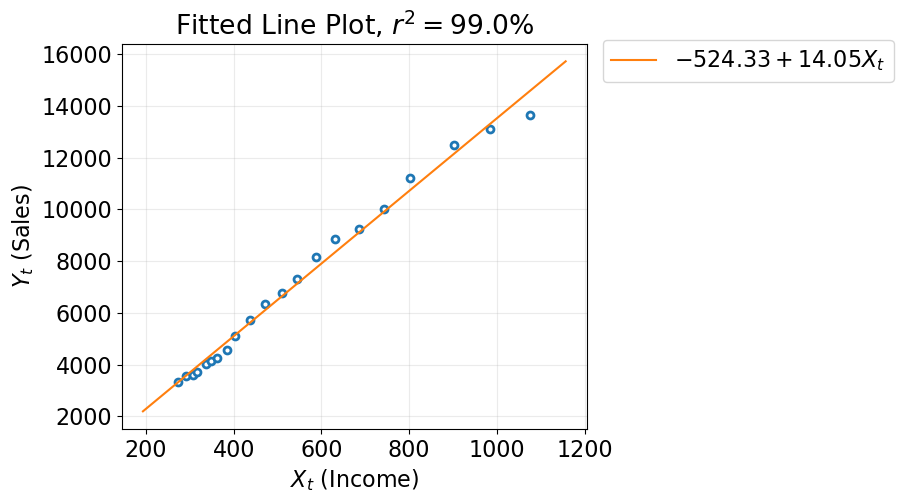

In [80]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(df_fit["X_1"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

regress = out_dict1["regress"]
b0 = regress.intercept_
b1 = regress.coef_[0]

data_t_min = df_fit["X_1"].min()
data_t_max = df_fit["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.2f} + {:.2f}X_t$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}X_t$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"$X_t$ (Income)")
ax.set_ylabel(r"$Y_t$ (Sales)")

rSq = out_dict1["R_sq"]
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

### Durbin-Watson Test

The *Durbin-Watson test* can be used to determine whether positive lag 1
autocorrelation is present.

$$
  \begin{gather*}
    \text{If } DW > d_\mathrm{U}, \text{ conclude } H_0: \rho = 0. \\
    \text{If } DW < d_\mathrm{L}, \text{ conclude } H_1: \rho > 0.
  \end{gather*}
$$

If $DW$ lies withing the lower and upper bounds $(d_\mathrm{L} \leq DW \leq d_\mathrm{U})$,
the test is inconclusive.

In [58]:
significance_lvl = [0.05, 0.01]
n_samples = len(df_minitab) 
k_predictors = 1
dw_stats = out_dict1["dw_stats"]

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 0.63
  durbin-watson critical values (d_L, d_U): (1.22, 1.42)
  conclusion: null hypotesis rejected

significance_lvl: 0.01
  durbin-watson statistics: 0.63
  durbin-watson critical values (d_L, d_U): (0.97, 1.16)
  conclusion: null hypotesis rejected



With a significant level $5\%$, the DW statistic is close to zero (null hypotesis is rejected). The positive autocorrelation is indicated.

## Generalized difference model

$$
\begin{align*}
  Y'_t = \beta_0 (1 - \rho) + \beta_1 X'_t + \nu_t
\end{align*}
$$

with $Y'_t = Y_t - \rho Y_{t-1}$ and $X'_t = X_t - \rho X_{t-1}$

In [12]:
df_generalized = df_minitab[["Y", "X_1"]]

df_generalized["diff Y"] = df_generalized["Y"] - df_generalized["Y"].shift(1)

df_generalized

,Y,X_1,diff Y
0,3307,273.4,NaN
1,3556,291.3,249.0
2,3601,306.9,45.0
3,3721,317.1,120.0
4,4036,336.1,315.0
5,4134,349.4,98.0
6,4268,362.9,134.0
7,4578,383.9,310.0
8,5093,402.8,515.0
9,5716,437.0,623.0


### Solve the estimated regressor using `lmfit`

In [13]:
def residual_func(params, x, y_data, x0, y0_data):
  """The following definition of residual_func is a little bit trickier.
     We have to separate the first value of x and y_data to make input/output
     array of x and y_data have the same dimension"""
  beta0 = params["beta0"].value
  beta1 = params["beta1"].value
  rho = params["rho"].value

  diff_x = np.zeros_like(x, dtype=float)
  diff_x[1:] = x[1:] - rho*x[:-1]
  diff_x[0] = x[0] - rho*x0
  
  diff_y_data = np.zeros_like(y_data, dtype=float)
  diff_y_data[1:] = y_data[1:] - rho*y_data[:-1]
  diff_y_data[0] = y_data[0] - rho*y0_data
  
  return diff_y_data - beta0*(1. - rho) - beta1*diff_x

def get_least_squares_with_lmfit(df, init_params):
  params = lmfit.Parameters()
  params.add("beta0", init_params[0])
  params.add("beta1", init_params[1])
  params.add("rho", init_params[2])

  x = df["X_1"].to_numpy()
  x0 = x[0]
  x = x[1:]
  y_data = df["Y"].to_numpy()
  y0_data = y_data[0]
  y_data = y_data[1:]
  ol = lmfit.minimize(residual_func, params, args=(x, y_data, x0, y0_data), 
    method="leastsq", ftol=1e-20)

  df["hat_Y"] = df["Y"] + np.hstack((np.nan, ol.residual))

  return ol, df

In [118]:
def get_eviews_out(df, init_params):
  
  # -- get regressor coefficient
  regress, df  = get_least_squares_with_lmfit(df, init_params)
  best_params = regress.last_internal_values     # [beta0, beta1, rho]
  var_names = regress.var_names
  n_vars = len(var_names)
  n_data = regress.ndata

  # -- compute standard error of the estimation, t-statistic,
  #    and p-values
  std_errs = np.zeros(n_vars, dtype=float)
  t_stats = np.zeros(n_vars, dtype=float)
  p_values = np.zeros(n_vars, dtype=float)
  dof = regress.ndata - n_vars - 1
  for i, var_name in enumerate(var_names):
    std_errs[i] = regress.params[var_name].stderr
    t_stats[i] = best_params[i] / std_errs[i]
    p_values[i] = sc_stats.t.sf(abs(t_stats[i]), dof) * 2

  # -- create tabular form for predictor
  data = [[]]
  for i, var_name in enumerate(var_names):
    data_row = [var_name, best_params[i], std_errs[i], t_stats[i], p_values[i]]
    data.append(data_row)
  
  table_predictor = tabulate.tabulate(data, tablefmt="html",
    headers=["Variable", "Coefficient", "Std. Error", "t-Statistic", "Prob."],
    floatfmt=[None, "8f", "8f", "8f", ".4f"])
  display(table_predictor)

  # print(std_errs)
  # print(t_stats)
  # print(p_values)

  # -- compute ANOVA table
  #    For nonlinear equation, we cannot compute R_sq from ssr/sst
  #    The relation  sst = ssr + sse, but you have to change the formula
  #    for R_sq and F_score to use sse and sst
  #    We cannot compute SSR from df["hat_Y"] - meanY because the regression
  #    is nonlinear, we have to compute from ssr = sst - sse
  #    And we have to change the d.o.f (see https://stats.stackexchange.com/a/256104)
  meanY = df["Y"].iloc[1:].mean()
  stddevY = np.std(df["Y"].iloc[1:], ddof=1)
  # ssr_manual = ((df["hat_Y"].iloc[1:] - meanY)**2).sum()      # sum of square regression
  sst = ((df["Y"][1:] - meanY)**2).sum()                      # sum of square total
  sse = ((df["Y"].iloc[1:] - df["hat_Y"].iloc[1:])**2).sum()  # sum of square residual
  ssr = sst - sse
  # print(f"ssr_manual: {ssr_manual}")
  # print(f"ssr: {ssr}")
  anova_sumSq = np.array([ssr, sse, sst])

  # -- degree of freedom for sse is (n_data - n_vars) 
  #    degree of freedom for ssr is (n_vars - 1)
  anova_dof = np.array([n_vars - 1, n_data - n_vars, n_data - 1])
  anova_meanSq = anova_sumSq/anova_dof
  anova_F_score = (sst/sse - 1) *(n_data - n_vars) / (n_vars - 1)
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])


  # -- compute R_sq (coefficient of determination)
  R_sq = 1 - sse/sst
  
  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(n_data-1)/(n_data - n_vars)

  # -- compute log-likelihood (https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf)
  #    Eq. (3)
  s = np.sqrt((regress.residual**2).sum() / n_data)
  log_likelihood = -n_data/2 * np.log(2.*np.pi) - n_data *np.log(s) \
    - (1./(2.*s**2) * (regress.residual**2).sum())

  # -- calcualte Durbin-Watson statistic
  e_t = regress.residual
  numerator = ((e_t[1:] - e_t[:-1])**2).sum()
  dw_stats = numerator / (e_t**2).sum()
  # print(dw_stats)

  data = [
    ["R-squared", R_sq, "Mean dependent var", meanY],
    ["Adjusted R-squared", adj_R_sq, "S.D dependent var", stddevY],
    ["S.E. of regression", np.sqrt(anova_meanSq[1]), "Akaike info criterion", np.nan],
    ["Sum squared resid", (e_t**2).sum(), "Schwarz criterion", np.nan],
    ["Log likelihood", log_likelihood, "F-statistic", anova_F_score],
    ["Durbin-Watson stat", dw_stats, "Prob(F-statistic)", anova_p_value]
  ]
  table_anova = tabulate.tabulate(data, tablefmt="html",
    floatfmt=[None, "8f", None, "8f"])

  display(table_anova)

  return {"regress": regress, "param_stderr": std_errs, 
    "param_t_stat": t_stats, "param_p_vals": p_values,
    "R_sq": R_sq, "dw_stats": dw_stats}


In [119]:
init_params = [50_000, 5, 0.5]
out_dict2 = get_eviews_out(df_generalized, init_params)

Variable,Coefficient,Std. Error,t-Statistic,Prob.
,,,,
beta0,54488.805740,3345687.932412,0.016286,0.9872
beta1,9.262376,7.240650,1.279219,0.2191
rho,0.997245,0.170084,5.863262,0.0000


R-squared,0.995227,Mean dependent var,7292.250000
Adjusted R-squared,0.994666,S.D dependent var,3377.321624
S.E. of regression,246.665853,Akaike info criterion,nan
Sum squared resid,1034348.730289,Schwarz criterion,nan
Log likelihood,-136.914273,F-statistic,1772.444487
Durbin-Watson stat,1.121974,Prob(F-statistic),0.000000


### Using `scipy.optimize.least_squares`

The result is not consistent, and it is hard to compute `hat_Y`

In [60]:
# def scalar_res_func(params, x_data, y_data):
#   beta0 = params[0]
#   beta1 = params[1]
#   rho = params[2]
#   diff_x = x_data[1:] - rho*x_data[:-1]
#   diff_y = y_data[1:] - rho*y_data[:-1]

#   return diff_y - beta0*(1. - rho) - beta1*diff_x


In [49]:
# def get_nonlinear_regress_coeff(df, params_init):

#   x_data = df_generalized["X_1"].to_numpy()
#   y_data = df_generalized["Y"].to_numpy()
#   optimize_out = sc_optimize.least_squares(scalar_res_func, params_init, 
#     args=(x_data, y_data), ftol=1e-14, xtol=1e-14)


#   estimated_beta0, estimated_beta1, estimated_rho = optimize_out.x
#   diff_X = np.zeros_like(x_data, dtype=float)
#   diff_X[1:] = x_data[1:] - estimated_rho*x_data[:-1]
#   diff_X[0] = np.nan
  
#   # This has to be computed recursively
#   hat_Y = np.zeros_like(y_data, dtype=float)
#   hat_Y[0] = np.nan
#   hat_Y[1] = estimated_rho*y_data[0] + estimated_beta0*(1. - estimated_rho) \
#     + estimated_beta1*diff_X[1]
  
#   for i in range(2, len(hat_Y)):
#     hat_Y[i] = estimated_rho*hat_Y[i-1] + estimated_beta0*(1. - estimated_rho) \
#       + estimated_beta1*diff_X[i]
  
#   df["hat_Y"] = hat_Y
#   return optimize_out, df 


# def get_eviews_out(df, params_init):
#   x_data = df["X_1"]
#   y_data = df["Y"]

#   # -- get regressor coeffcient
#   regress, df = get_nonlinear_regress_coeff(df, params_init)
#   display(df)
#   beta0, beta1, rho = regress.x

#   # -- computer standard error of the estimation
#   num_of_samples = len(df) - 1   # first row is NaN




#   return None

# params_init = [50_000, 5, 0.5]
# get_eviews_out(df_generalized, params_init)

### The Durbin-Watson test

The *Durbin-Watson test* can be used to determine whether positive lag 1
autocorrelation is present.

$$
  \begin{gather*}
    \text{If } DW > d_\mathrm{U}, \text{ conclude } H_0: \rho = 0. \\
    \text{If } DW < d_\mathrm{L}, \text{ conclude } H_1: \rho > 0.
  \end{gather*}
$$

If $DW$ lies withing the lower and upper bounds $(d_\mathrm{L} \leq DW \leq d_\mathrm{U})$,
the test is inconclusive.

In [61]:
significance_lvl = [0.05, 0.01]
n_samples = out_dict2["regress"].ndata
k_predictors = len(out_dict2["regress"].var_names)
dw_stats = out_dict2["dw_stats"]

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 1.12
  durbin-watson critical values (d_L, d_U): (1.0, 1.68)
  conclusion: inconclusive

significance_lvl: 0.01
  durbin-watson statistics: 1.12
  durbin-watson critical values (d_L, d_U): (0.77, 1.41)
  conclusion: inconclusive



Because of the inclusive result Durbin-Watson test, we explore the correlogram
plot to check that the residual is within the selected significance level

### Correlogram plot

In [99]:
df_correlogram = df_minitab[["Y", "X_1"]]
df_correlogram["e_t"] = np.hstack((np.nan, out_dict2["regress"].residual))
df_correlogram["t"] = np.arange(1, len(df_correlogram)+1, dtype=int)
df_correlogram = df_correlogram.dropna()
df_correlogram

,Y,X_1,e_t,t
1,3556,291.3,-64.784740,2
2,3601,306.9,-247.252041,3
3,3721,317.1,-122.509325,4
4,4036,336.1,-8.947912,5
5,4134,349.4,-172.769369,6
6,4268,362.9,-138.691244,7
7,4578,383.9,-32.134383,8
8,5093,402.8,192.634794,9
9,5716,437.0,159.857017,10
10,6357,472.2,169.438328,11


In [100]:
num_of_rk = 5
df_acorr_analysis = get_correlogram(df_correlogram, num_of_rk, columns=['t', 'e_t'])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.333603,1.491916,2.577257,-0.468014,0.468014
1,2,-0.395738,-1.600602,6.405459,-0.517485,0.517485
2,3,-0.189828,-0.685027,7.338119,-0.579998,0.579998
3,4,0.333829,1.177371,10.402760,-0.593450,0.593450
4,5,0.186415,0.616143,11.422109,-0.633248,0.633248


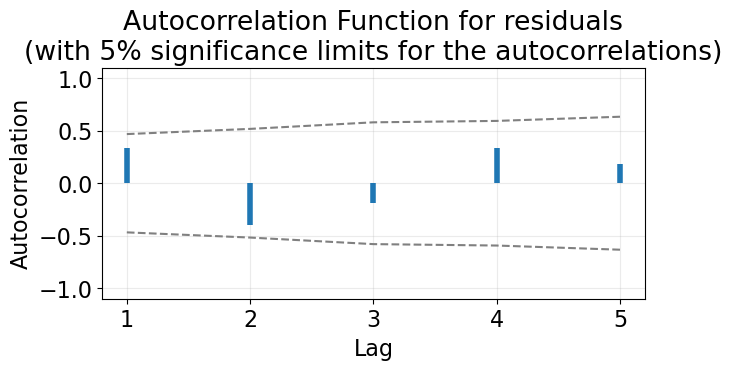

In [101]:
plot_autocorr_func(df_acorr_analysis, title=r"residuals")

The correlogram plot above shows that the autocorrelation of the 
residuals are wll within their two standard error limits (the dashed lines
in the fitures)

## Comparison between two regression models

In [108]:
out_dict2["regress"].params["beta1"].stderr

7.240650089180273

In [125]:
beta1_model1 = out_dict1["regress"].coef_.tolist()[0]
beta1_model2 = out_dict2["regress"].params["beta1"].value
beta1_stderr_model1 = out_dict1["param_stderr"][1]
beta1_stderr_model2 = out_dict2["regress"].params["beta1"].stderr
beta1_t_stat_model1 = out_dict1["param_t_stat"][1]
beta1_t_stat_model2 = out_dict2["param_t_stat"][1]
beta1_p_vals_model1 = out_dict1["param_p_vals"][1]
beta1_p_vals_model2 = out_dict2["param_p_vals"][1]

data = [
  ["beta1", beta1_model1, beta1_model2],
  ["beta1 std. err", beta1_stderr_model1, beta1_stderr_model2], 
  ["beta1 t_stat", beta1_t_stat_model1, beta1_t_stat_model2],
  ["beta1 p_value", beta1_p_vals_model1, beta1_p_vals_model2]
]

table_comparison = tabulate.tabulate(data, tablefmt="html",
  headers=["", "model 1", "model 2"],
  floatfmt=[None, ".3f", ".3f"])

display(table_comparison)
print(f"rho: {out_dict2['regress'].params['rho'].value}")


,model 1,model 2
beta1,14.050,9.262
beta1 std. err,0.319,7.241
beta1 t_stat,44.112,1.279
beta1 p_value,0.000,0.219


rho: 0.9972448928132901


The strong serial correlation ($rho = 0.997$) has little effect
on the estimate of the slope coefficient in the relation between $Y$
and $X$ ($p$-value of model 2 is not significantly different from zero).
However, the strong (positive) serial correlation does result in 
sever underestimate of the standard errro of the estimated slope 
coefficient. Indded, one reason for adjusting for serial correlation
is to avoid making mistakes of inference because of $t$-statistic values that are
to large.

Finally, $\hat{\rho} = 0.997$ is very close to 1. This suggest that the 
relationship between $Y$ and $X$ might be represented by a simple linear
regression model with the differences    
$Y'_t = Y_t - Y_{t-1}$ and
$X'_t = X_t - X_{t-1}$